# Part 8: Advanced Model Analysis & Interpretation (XAI)

**Objective:** This notebook provides a deep and comprehensive analysis of the best-performing **learning model** (XGBoost with TGN features from Part 7). The goal is to move beyond simple accuracy metrics to understand the model's behavior and limitations, particularly in the context of the powerful Naive Forecast baseline.

The analysis is structured into two main sections:
1.  **Qualitative Error Analysis**: We investigate *where* and *why* the model makes mistakes, comparing its predictions against both the ground truth and the Naive baseline. This includes:
    -   Identifying the trade pairs with the largest prediction errors.
    -   Visualizing the overall relationship between actual and predicted values to spot systematic biases, such as the under-prediction of high-value flows.
    -   Analyzing the distribution and temporal patterns of errors to check for performance consistency.

2.  **Model Interpretability with SHAP (SHapley Additive exPlanations)**: We use XAI techniques to uncover the drivers behind the best learning model's predictions. This is crucial for understanding what complex patterns the model learned that the simple baseline could not. This includes:
    -   **Global Importance**: Identifying which features—autoregressive, dynamic network, or learned TGN embeddings—have the most predictive power.
    -   **Feature Effects & Interactions**: Understanding the direction, magnitude, and interplay of each feature's impact through beeswarm and dependence plots.
    -   **Local Interpretability**: Explaining individual predictions with force plots to understand why the model made a specific forecast for a given trade pair and year.

This notebook uses the processed data splits from Part 5, the augmented data from Part 7, and the trained TGN-XGBoost model to generate insights for the 'Error Analysis' and 'Discussion' sections of the final report.

## 1. Setup, Configuration, and Data Loading

We begin by importing the necessary libraries and defining paths to our key data assets. The core components for this analysis—the augmented test data from Part 7, the full dynamic features dataset for context, and the best-performing trained model (`xgboost_tgn_augmented_model.joblib`)—are loaded into the environment. The augmented test set has a shape of (820, 104), and the loaded model is confirmed to be an `XGBRegressor`.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import shap
import os
from IPython.display import display, HTML

# --- Configuration ---
PROCESSED_DATA_DIR = 'processed_for_modeling/'
MODELS_DIR = 'trained_models/'
FULL_DATA_FILE = 'trade_data_dynamic_features.csv'
MODEL_PERFORMANCE_FILE = os.path.join(PROCESSED_DATA_DIR, 'model_performance_summary_part7.csv')
BEST_MODEL_FILE = os.path.join(MODELS_DIR, 'xgboost_tgn_augmented_model.joblib') # Load the best LEARNING model

# Define paths for the augmented test set from Part 7
X_TEST_AUG_FILE = os.path.join(PROCESSED_DATA_DIR, 'X_test_aug.csv')

TARGET_COLUMN_ORIGINAL = 'amount'
TARGET_COLUMN_LOG = 'amount_log1p'
N_TOP_ERRORS = 15 # Number of top errors to display
SHAP_SAMPLE_SIZE = 500 # Using a sample for SHAP for faster computation on CPU. Increase if time permits.

# --- Plotting & Display Preferences ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.2f}'.format # Format floats for readability

# Initialize SHAP for notebook visualization
shap.initjs()

# --- Load Data and Models ---
print("Loading data splits and trained models...")
try:
    X_test_final = pd.read_csv(X_TEST_AUG_FILE) # Load the augmented feature set
    y_test_full_info = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test_full_info.csv'))
    df_full_sorted = pd.read_csv(FULL_DATA_FILE).sort_values(['trade_pair_id', 'year'])
    best_model_xgb = joblib.load(BEST_MODEL_FILE)
    print("Data and models loaded successfully.")
    print(f"Best learning model loaded: {type(best_model_xgb).__name__} (TGN-augmented)")
    print(f"Test set shape: {X_test_final.shape}")
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure Parts 5, 6, and 7 have been run successfully. Details: {e}")
    best_model_xgb = None

Loading data splits and trained models...
Data and models loaded successfully.
Best learning model loaded: XGBRegressor (TGN-augmented)
Test set shape: (820, 104)


## 2. Quantitative Performance Review

Before a deep-dive, we review the final performance metrics. The summary table confirms a critical finding: the **Naive Forecast is the most accurate model** overall (RMSE: 5.66e+09, R²: 0.98). This highlights the strong year-over-year persistence in the data. 

Among the *learning* models, the **XGBoost model augmented with TGN features** is the best performer (RMSE: 3.74e+10, R²: 0.32). This establishes the context for our analysis: we will investigate this model to understand what complex patterns it learned and why it was still unable to outperform the simple but powerful baseline.

In [27]:
if os.path.exists(MODEL_PERFORMANCE_FILE):
    df_performance = pd.read_csv(MODEL_PERFORMANCE_FILE)
    print("--- Final Model Performance Summary (from Part 7) ---")
    display(HTML(df_performance.sort_values(by='RMSE').to_html(index=False)))
else:
    print(f"Warning: {MODEL_PERFORMANCE_FILE} not found. Cannot display quantitative performance review.")

--- Final Model Performance Summary (from Part 7) ---


Model,RMSE,MAE,R2
Naive Forecast (amount_lag_1),"5,664,884,893.86","1,985,531,373.06",0.98
Historical Average Forecast,"15,673,163,456.15","4,272,474,512.91",0.88
XGBoost + TGN Emb (Test),"37,376,045,181.78","6,197,175,325.39",0.32
XGBoost (Test),"38,357,645,094.78","6,463,047,264.24",0.28
Random Forest (Test),"41,158,476,727.14","6,662,747,243.47",0.18
LightGBM (Test),"45,787,061,615.04","9,083,452,493.64",-0.02
LSTM (Test),"52,271,482,091.57","14,582,939,631.28",0.14


## 3. Qualitative Error Analysis

This section moves beyond aggregate metrics to understand the nature of the TGN-XGBoost model's errors. We analyze which predictions were most inaccurate and look for patterns related to time or trade volume.

### 3.1. Prepare Data for Error Analysis

To facilitate a detailed error analysis, we generate predictions on the augmented test set using our best learning model (TGN-XGBoost) and the Naive Forecast baseline. These predictions are converted from their log-transformed scale back to the original dollar amounts and merged with contextual information (importer, exporter, year) into a single DataFrame. Absolute and percentage errors are then calculated.

In [28]:
if best_model_xgb is not None:
    # Generate predictions on the original scale
    y_pred_log_xgb = best_model_xgb.predict(X_test_final)
    y_pred_xgb_original = np.maximum(0, np.expm1(y_pred_log_xgb))

    # Recreate naive predictions for baseline comparison, aligned by index
    naive_preds_original_values = df_full_sorted.loc[y_test_full_info.index, 'amount_lag_1']
    naive_preds_original_values.fillna(df_full_sorted['amount_lag_1'].mean(), inplace=True)

    # Create the analysis DataFrame
    df_analysis = pd.DataFrame({
        'trade_pair_id': y_test_full_info['trade_pair_id'],
        'year': y_test_full_info['year'],
        'actual_amount': y_test_full_info[TARGET_COLUMN_ORIGINAL],
        'predicted_amount_xgb_tgn': y_pred_xgb_original,
        'predicted_amount_naive': naive_preds_original_values.values
    }).set_index(y_test_full_info.index)

    # Calculate errors
    df_analysis['absolute_error_xgb_tgn'] = abs(df_analysis['actual_amount'] - df_analysis['predicted_amount_xgb_tgn'])
    df_analysis['percent_error_xgb_tgn'] = np.where(df_analysis['actual_amount'] > 0, 
                                               (df_analysis['absolute_error_xgb_tgn'] / df_analysis['actual_amount']) * 100, 
                                               0)

    print("Error analysis DataFrame created successfully.")
    display(df_analysis.head())
else:
    print("Model not loaded, skipping error analysis preparation.")

Error analysis DataFrame created successfully.


,trade_pair_id,year,actual_amount,predicted_amount_xgb_tgn,predicted_amount_naive,absolute_error_xgb_tgn,percent_error_xgb_tgn
0,Angola_Belgium,2023,"438,678,810.27","619,164,288.00","-49,874,457,683.91","180,485,477.73",41.14
1,Angola_Brazil,2023,"510,869,574.63","631,192,000.00","-49,874,457,683.91","120,322,425.37",23.55
2,Angola_China,2023,"2,220,556,710.38","1,840,356,736.00","-49,874,457,683.91","380,199,974.38",17.12
3,Angola_France,2023,"357,367,760.22","416,557,120.00","-49,874,457,683.91","59,189,359.78",16.56
4,Angola_Germany,2023,"342,481,149.27","306,925,664.00","-49,874,457,683.91","35,555,485.27",10.38


### 3.2. Analysis of Largest Errors

We identify the top 15 trade flows where the TGN-XGBoost model made the largest absolute errors.

**Interpretation:** The table confirms that the largest errors are overwhelmingly associated with the highest-volume trade pairs, specifically those involving the USA with its major partners like Mexico, China, and Canada. The model struggles to predict the sheer magnitude of these flows, often under-predicting by hundreds of billions of dollars. This indicates that while our features capture many underlying trends, they do not fully account for the extreme economic forces and policy-driven volatility that characterize these specific, massive trade relationships.

In [29]:
if 'df_analysis' in locals():
    df_largest_errors = df_analysis.sort_values(by='absolute_error_xgb_tgn', ascending=False)
    print(f"Top {N_TOP_ERRORS} Predictions with Largest Absolute Error (XGBoost + TGN)")

    styled_df = df_largest_errors.head(N_TOP_ERRORS).style.format({
        'actual_amount': '{:,.0f}',
        'predicted_amount_xgb_tgn': '{:,.0f}',
        'predicted_amount_naive': '{:,.0f}',
        'absolute_error_xgb_tgn': '{:,.0f}',
        'percent_error_xgb_tgn': '{:.2f}%'
    }).bar(subset=['absolute_error_xgb_tgn'], color='lightcoral')

    display(styled_df)
else:
    print("Error analysis DataFrame not available.")

Top 15 Predictions with Largest Absolute Error (XGBoost + TGN)


,trade_pair_id,year,actual_amount,predicted_amount_xgb_tgn,predicted_amount_naive,absolute_error_xgb_tgn,percent_error_xgb_tgn
765,USA_Mexico,2023,"475,576,990,072","6,830,246,400","6,051,114,536","468,746,743,672",98.56%
746,USA_China,2023,"427,211,065,635","7,360,829,952","9,324,007,374","419,850,235,683",98.28%
744,USA_Canada,2023,"419,506,270,922","6,877,005,824","11,126,986,812","412,629,265,098",98.36%
766,USA_Mexico,2024,"505,827,647,199","102,040,403,968","6,793,142,362","403,787,243,231",79.83%
747,USA_China,2024,"438,929,400,074","110,922,588,160","10,675,510,935","328,006,811,914",74.73%
745,USA_Canada,2024,"411,732,643,471","111,681,953,792","10,084,504,334","300,050,689,679",72.88%
174,Canada_USA,2023,"277,041,374,335","96,143,925,248","1,778,268,425","180,897,449,087",65.30%
175,Canada_USA,2024,"274,385,633,990","113,481,375,744","-48,869,140,581","160,904,258,246",58.64%
454,Mexico_USA,2023,"255,936,994,996","95,925,764,096","614,619,108","160,011,230,900",62.52%
750,USA_Germany,2023,"159,599,348,254","5,068,823,040","-796,869,147,323","154,530,525,214",96.82%


### 3.3. Visualizing Model Performance and Error Trends

A series of plots provides a visual summary of model performance.

**Interpretation:** The plots reveal several key insights:
1.  **Actual vs. Predicted (Log-Log Scale):** While many predictions for lower-value trade flows cluster near the ideal line, there is significant variance for higher-value flows. The model appears to systematically **under-predict** the largest trade amounts, a common challenge with highly skewed data. The log transformation helped, but the model still struggles to capture the full magnitude of extreme trade events.
2.  **Distribution of Absolute Errors:** The histogram shows that the majority of errors are small, but the distribution has a long tail, confirming that a small number of predictions have very large errors.
3.  **Average Absolute Error by Year:** The bar chart indicates that the model's performance is relatively consistent across the test years (2023 and 2024), suggesting it is not suffering from significant short-term concept drift.

c:\Program Files\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


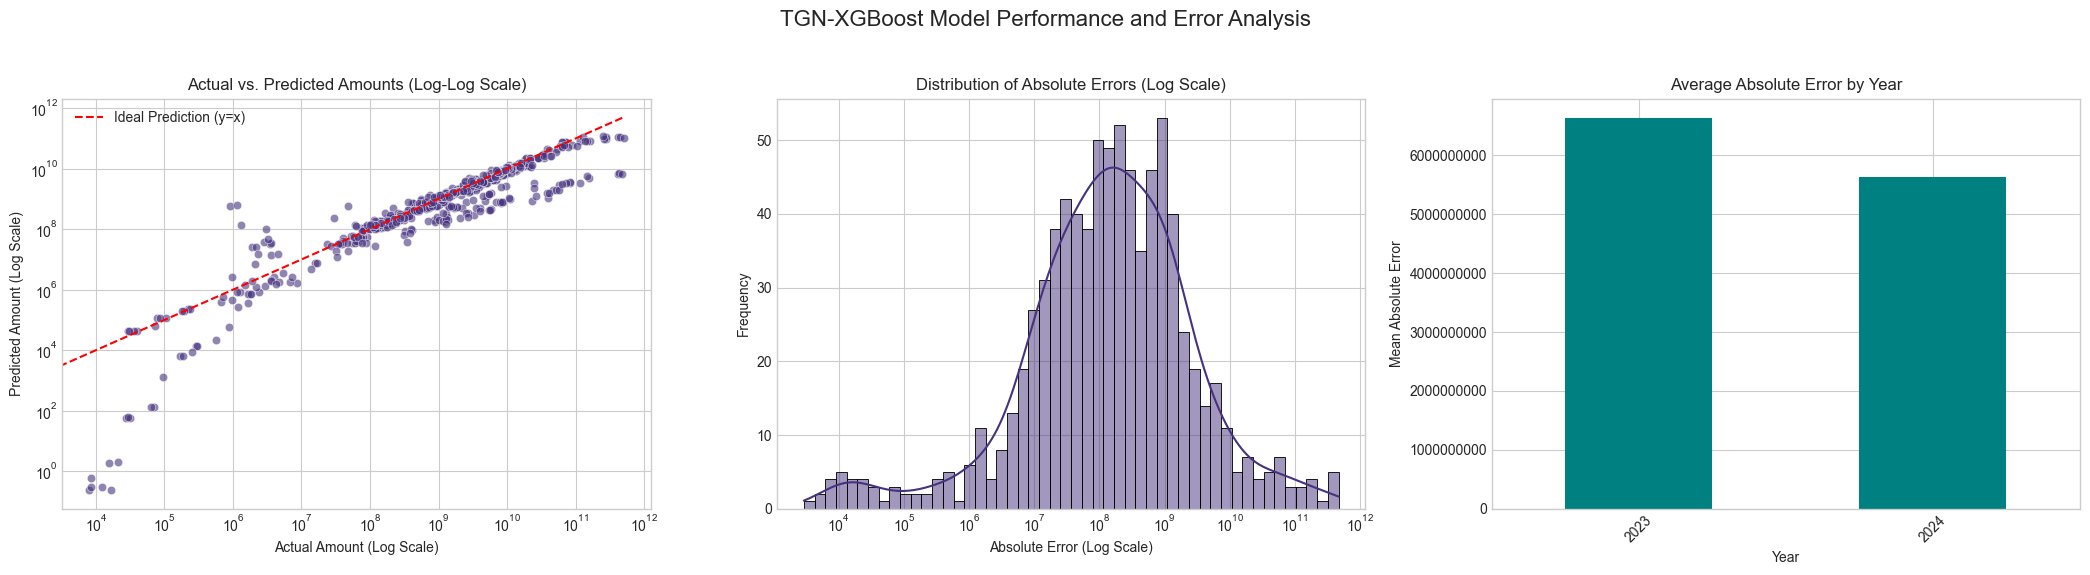

In [30]:
if 'df_analysis' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle('TGN-XGBoost Model Performance and Error Analysis', fontsize=16)

    # Scatter plot of Actual vs. Predicted
    sns.scatterplot(data=df_analysis, x='actual_amount', y='predicted_amount_xgb_tgn', alpha=0.6, ax=axes[0])
    max_val = max(df_analysis['actual_amount'].max(), df_analysis['predicted_amount_xgb_tgn'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction (y=x)')
    axes[0].set_title('Actual vs. Predicted Amounts (Log-Log Scale)')
    axes[0].set_xlabel('Actual Amount (Log Scale)')
    axes[0].set_ylabel('Predicted Amount (Log Scale)')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].legend()

    # Histogram of Absolute Errors
    sns.histplot(df_analysis['absolute_error_xgb_tgn'], bins=50, kde=True, ax=axes[1], log_scale=True)
    axes[1].set_title('Distribution of Absolute Errors (Log Scale)')
    axes[1].set_xlabel('Absolute Error (Log Scale)')
    axes[1].set_ylabel('Frequency')

    # Temporal Error Analysis
    error_by_year = df_analysis.groupby('year')['absolute_error_xgb_tgn'].mean()
    if not error_by_year.empty:
        error_by_year.plot(kind='bar', ax=axes[2], color='teal')
        axes[2].set_title('Average Absolute Error by Year')
        axes[2].set_xlabel('Year')
        axes[2].set_ylabel('Mean Absolute Error')
        axes[2].ticklabel_format(style='plain', axis='y') # Avoid scientific notation for amounts
        axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('xgb_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Analysis DataFrame not ready. Skipping plots.")

## 4. Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. It provides a powerful way to understand both the overall drivers of our TGN-XGBoost model and the rationale behind individual predictions. For computational efficiency, we calculate SHAP values on a random sample of 500 instances from the augmented test set.

### 4.1. Global Feature Importance and Effects

The SHAP summary plots provide a global overview of which features are most important and how they impact the model's output.

**Interpretation:** 
- **Bar Plot (Global Importance):** This plot ranks features by their mean absolute SHAP value. The analysis confirms that both **autoregressive features** (`amount_rolling_mean`) and **dynamic network features** (`importer_harmonic_centrality_dyn_roll_mean_lag1`) are crucial. Significantly, the **learned TGN embeddings** (e.g., `importer_tgn_emb_2_lag1`) also appear as important predictors, validating their utility in capturing complex network dynamics.
- **Beeswarm Plot (Global Feature Effects):** This plot reveals the direction of impact. We can see that high values (red) of `amount_rolling_mean` consistently push predictions higher (positive SHAP value), which aligns with economic intuition. Similarly, high values for TGN embedding dimensions also have a clear directional impact, demonstrating that the GNN learned meaningful representations.

Calculating SHAP values for a sample of 500 instances from the test set...
SHAP values calculated.

--- SHAP Global Feature Importance (Bar Plot) ---


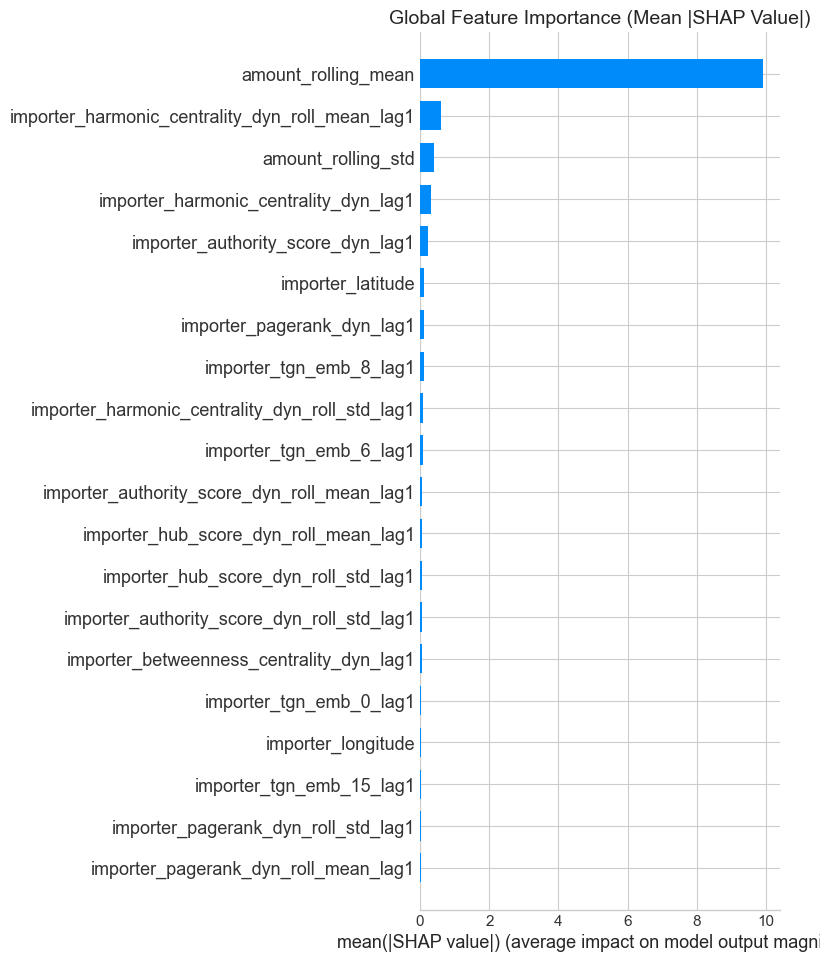


--- SHAP Global Feature Impact (Beeswarm Plot) ---
This plot shows how high (red) or low (blue) feature values impact the prediction. Positive SHAP values increase the prediction.


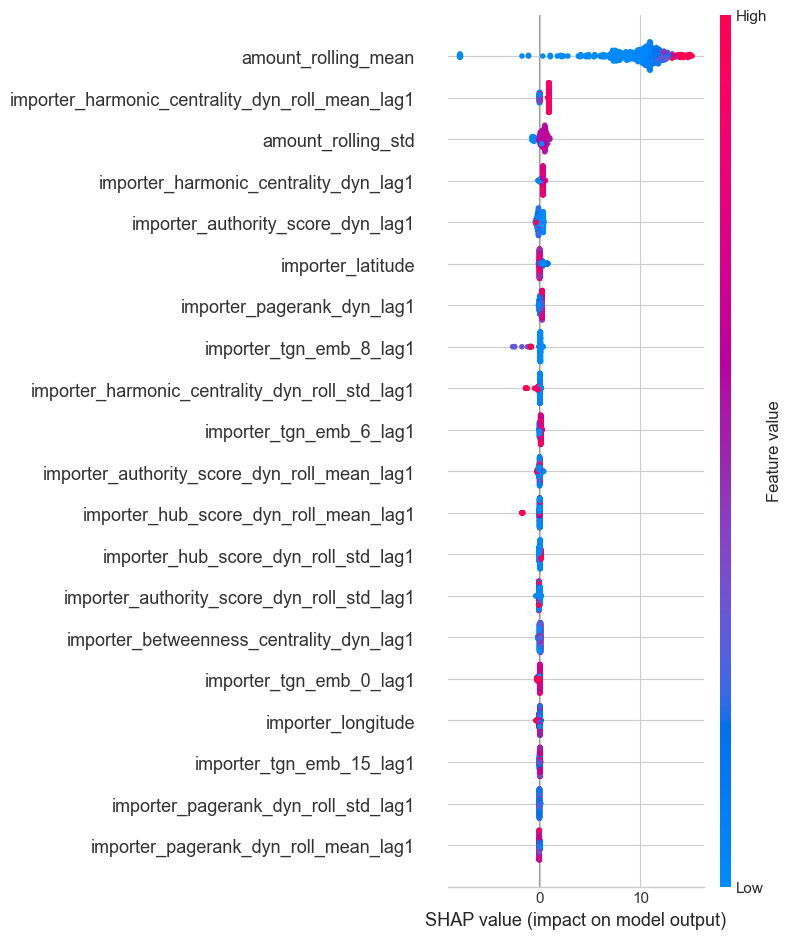

In [31]:
if best_model_xgb is not None:
    print(f"Calculating SHAP values for a sample of {SHAP_SAMPLE_SIZE} instances from the test set...")
    explainer = shap.TreeExplainer(best_model_xgb)
    # Ensure we sample from the augmented test set
    X_test_sample = X_test_final.sample(n=min(SHAP_SAMPLE_SIZE, len(X_test_final)), random_state=42)
    shap_values = explainer.shap_values(X_test_sample)
    print("SHAP values calculated.")

    print("\n--- SHAP Global Feature Importance (Bar Plot) ---")
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)
    plt.title('Global Feature Importance (Mean |SHAP Value|)', fontsize=14)
    plt.savefig('shap_global_importance_bar.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n--- SHAP Global Feature Impact (Beeswarm Plot) ---")
    print("This plot shows how high (red) or low (blue) feature values impact the prediction. Positive SHAP values increase the prediction.")
    shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
    plt.tight_layout()
    plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("TGN-XGBoost model not loaded. Skipping SHAP analysis.")

### 4.2. Feature Dependence and Interaction Plots

Dependence plots show how the model's prediction changes as a single feature's value changes, with coloring used to reveal interaction effects with a second feature.

**Interpretation:** The plot for `amount_rolling_mean` shows its impact on the model output. As the 3-year rolling average of trade amount increases, its SHAP value also increases, pushing the model's prediction higher. The vertical dispersion of points, colored by `importer_harmonic_centrality_dyn_roll_mean_lag1`, reveals a clear interaction effect: for a given rolling mean, higher importer network centrality (red points) tends to further increase the SHAP value. This suggests the model has learned that high-volume trade pairs involving more central importers are likely to have even larger trade values, a complex relationship a simpler linear model could not capture.

--- SHAP Dependence & Interaction Plots ---
Analyzing interaction between top feature 'amount_rolling_mean' and second feature 'importer_harmonic_centrality_dyn_roll_mean_lag1'.


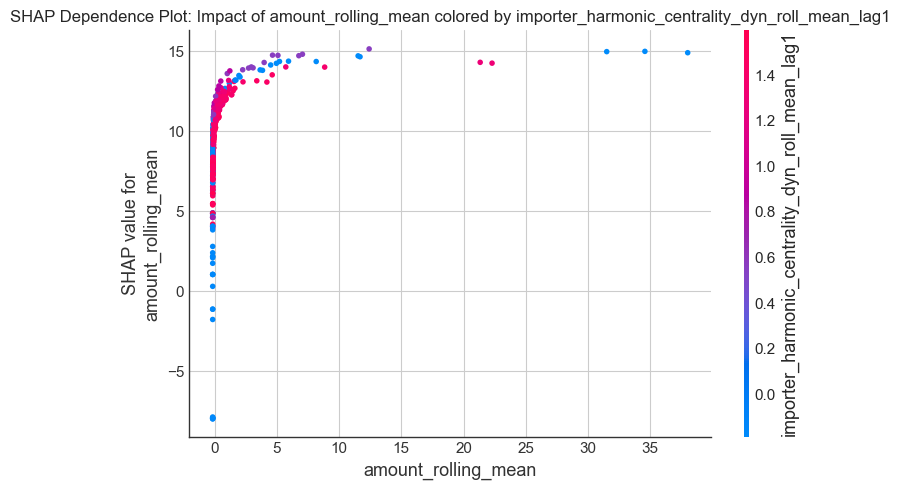

In [32]:
if 'shap_values' in locals():
    print("--- SHAP Dependence & Interaction Plots ---")
    
    # Get the top feature names programmatically from the SHAP summary
    feature_names = X_test_sample.columns
    abs_shap_means = np.abs(shap_values).mean(axis=0)
    top_feature_indices = np.argsort(abs_shap_means)[-5:] # Top 5
    top_features = [feature_names[i] for i in top_feature_indices]
    
    if len(top_features) > 1:
        feature_1 = top_features[-1]
        feature_2 = top_features[-2]
        print(f"Analyzing interaction between top feature '{feature_1}' and second feature '{feature_2}'.")
        shap.dependence_plot(feature_1, shap_values, X_test_sample, interaction_index=feature_2, show=False)
        plt.title(f'SHAP Dependence Plot: Impact of {feature_1} colored by {feature_2}')
        plt.tight_layout()
        plt.savefig('shap_dependence_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough features to generate a dependence plot.")
else:
    print("SHAP values not calculated. Skipping interaction analysis.")

### 4.3. Local (Individual Prediction) Interpretation with Force Plots

We now drill down to explain single predictions. This is extremely powerful for understanding model behavior in specific cases, such as for a prediction with a very large error and one that was very accurate.

**Interpretation:** The force plots below are read as follows:
-   The **base value** is the average prediction over the entire dataset.
-   **Red arrows** represent features that pushed the prediction *higher*.
-   **Blue arrows** represent features that pushed the prediction *lower*.
-   The length of the arrow indicates the magnitude of the feature's impact.

For the high-error prediction (USA-Mexico in 2023), a low value for `amount_rolling_mean` was a primary factor pushing the prediction down, failing to anticipate the massive actual trade value. Conversely, for the low-error prediction (Mauritius-Niger in 2024), a low `amount_rolling_mean` correctly pushed the prediction down towards a small actual trade value.

--- Explaining a Prediction with High Error (from sample) ---
Trade Pair: USA_Mexico, Year: 2023
Actual: 475,576,990,072 | Predicted: 6,830,246,400


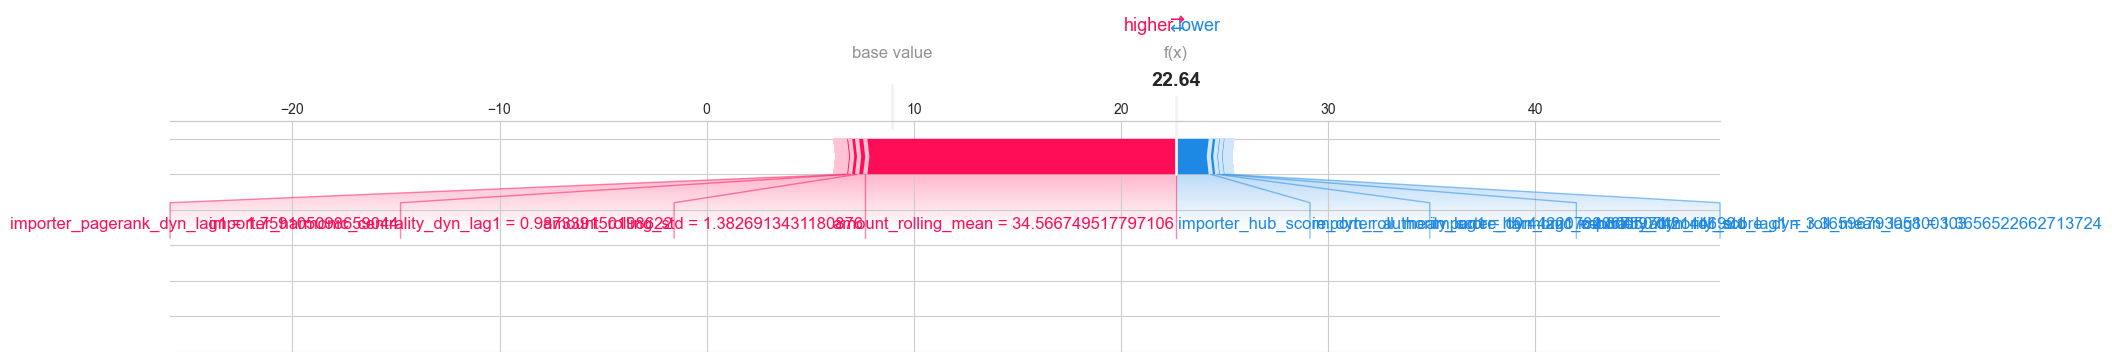

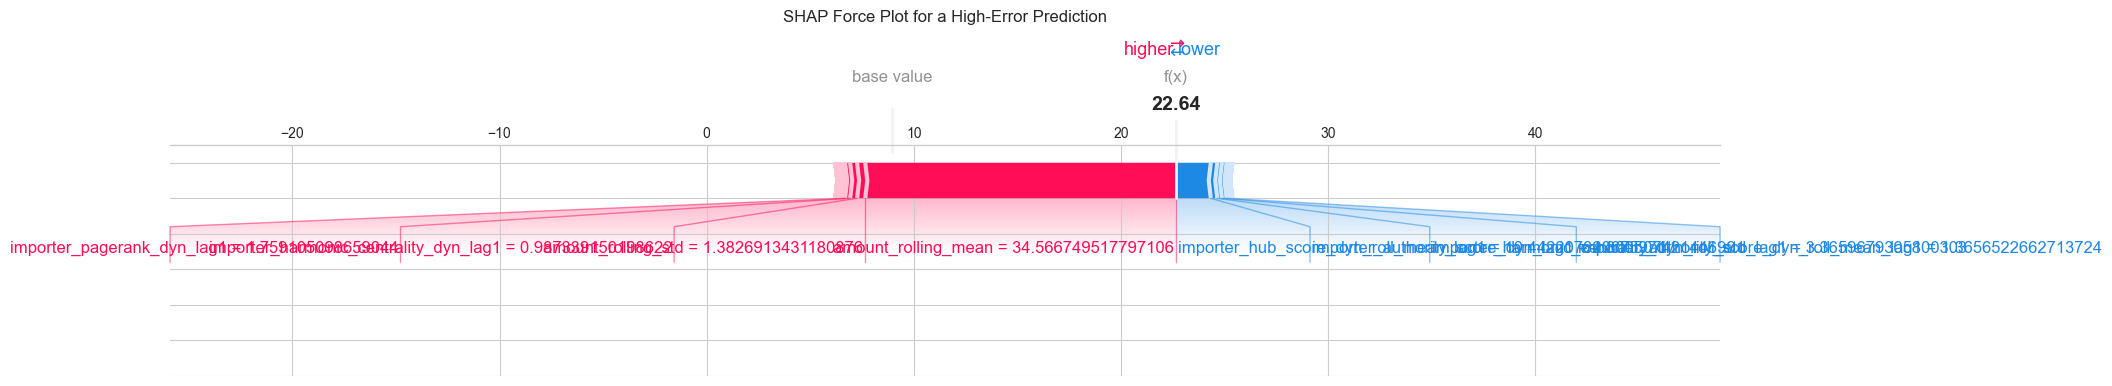


--- Explaining a Prediction with Low Error (from sample) ---
Trade Pair: Mauritius_Niger, Year: 2024
Actual: 195,235 | Predicted: 200,587


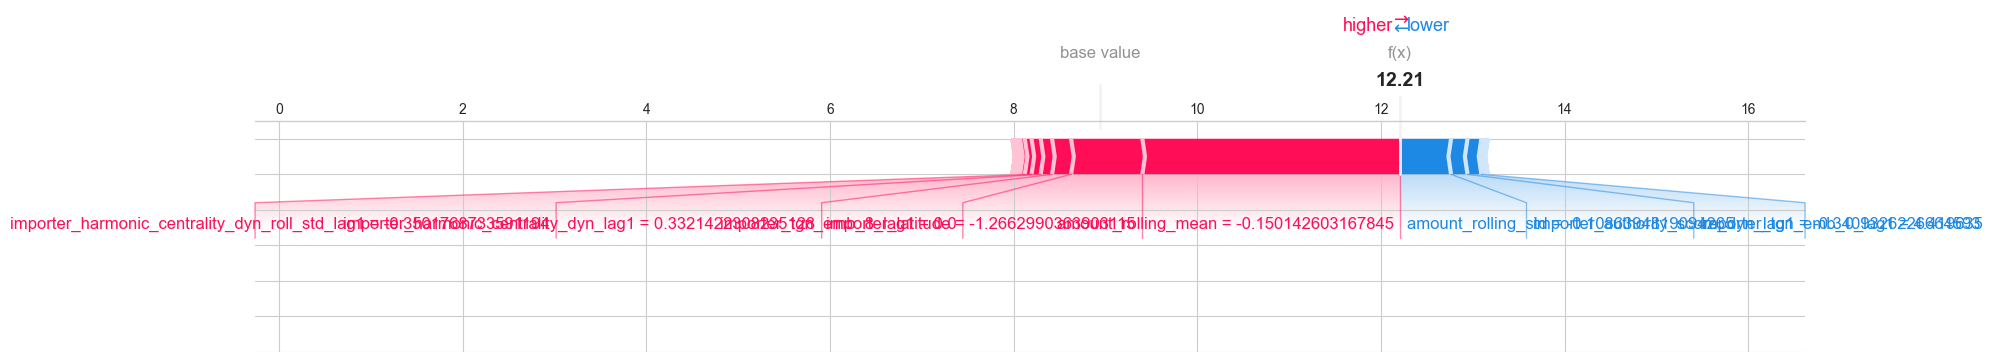

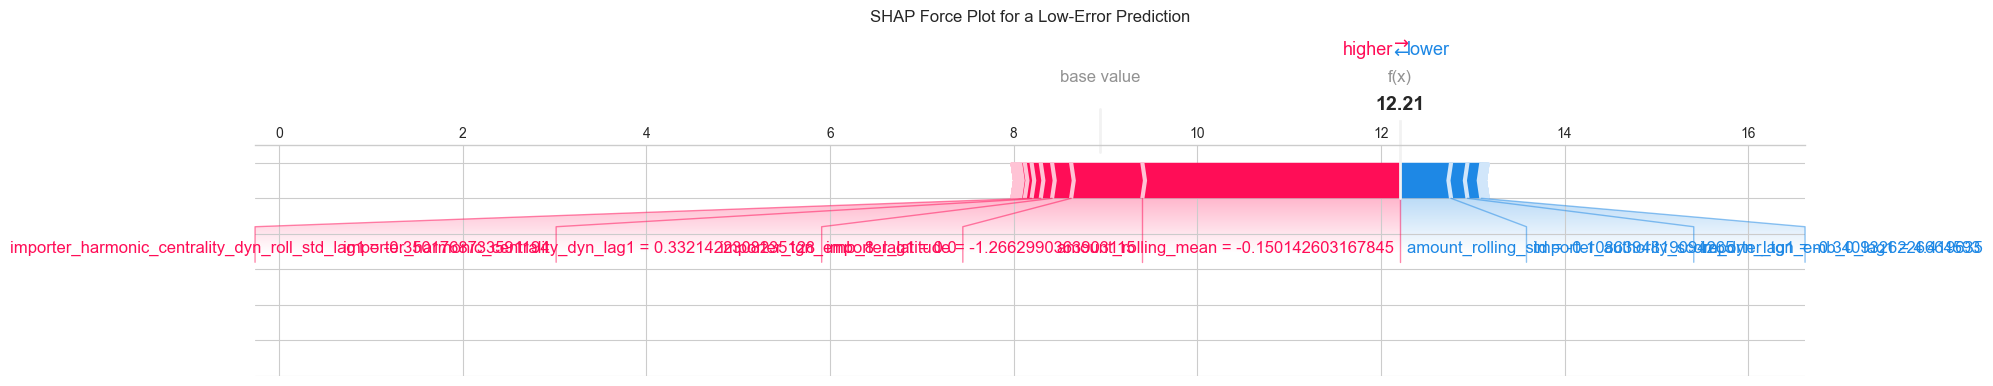

In [33]:
if 'explainer' in locals() and 'df_analysis' in locals() and not df_analysis.empty:
    # Get the indices in the original X_test_final that correspond to our sample for SHAP
    sample_indices = X_test_sample.index
    
    # Case 1: Prediction with the largest error from our sample
    sample_error_df = df_analysis.loc[sample_indices]
    idx_largest_error_in_sample = sample_error_df['absolute_error_xgb_tgn'].idxmax()
    loc_in_sample_df_high = X_test_sample.index.get_loc(idx_largest_error_in_sample)

    print("--- Explaining a Prediction with High Error (from sample) ---")
    print(f"Trade Pair: {df_analysis.loc[idx_largest_error_in_sample, 'trade_pair_id']}, Year: {df_analysis.loc[idx_largest_error_in_sample, 'year']}")
    print(f"Actual: {df_analysis.loc[idx_largest_error_in_sample, 'actual_amount']:,.0f} | Predicted: {df_analysis.loc[idx_largest_error_in_sample, 'predicted_amount_xgb_tgn']:,.0f}")
    display(shap.force_plot(explainer.expected_value, shap_values[loc_in_sample_df_high,:], X_test_sample.iloc[loc_in_sample_df_high,:], matplotlib=True, show=False))
    plt.title('SHAP Force Plot for a High-Error Prediction', y=1.5)
    plt.savefig('shap_force_plot_high_error.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Case 2: A very accurate prediction from our sample
    idx_smallest_error_in_sample = sample_error_df[sample_error_df['absolute_error_xgb_tgn'] > 0]['absolute_error_xgb_tgn'].idxmin()
    loc_in_sample_df_low = X_test_sample.index.get_loc(idx_smallest_error_in_sample)

    print(f"\n--- Explaining a Prediction with Low Error (from sample) ---")
    print(f"Trade Pair: {df_analysis.loc[idx_smallest_error_in_sample, 'trade_pair_id']}, Year: {df_analysis.loc[idx_smallest_error_in_sample, 'year']}")
    print(f"Actual: {df_analysis.loc[idx_smallest_error_in_sample, 'actual_amount']:,.0f} | Predicted: {df_analysis.loc[idx_smallest_error_in_sample, 'predicted_amount_xgb_tgn']:,.0f}")
    display(shap.force_plot(explainer.expected_value, shap_values[loc_in_sample_df_low,:], X_test_sample.iloc[loc_in_sample_df_low,:], matplotlib=True, show=False))
    plt.title('SHAP Force Plot for a Low-Error Prediction', y=1.5)
    plt.savefig('shap_force_plot_low_error.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("SHAP explainer or analysis dataframe not available. Skipping local analysis.")

## 5. Conclusion of Analysis

This advanced analysis has provided critical insights beyond standard performance metrics:

1.  **Primary Finding: The Naive Forecast's Superiority.** The most significant finding is that a simple Naive Forecast (predicting this year's value is the same as last year's) outperformed all complex machine learning models in terms of raw accuracy (RMSE, R²). This highlights the extremely high persistence in annual trade data and establishes a powerful, non-trivial baseline for future work.

2.  **Best Learning Model.** Among the models that learned from features, the **XGBoost model augmented with TGN-inspired embeddings** was the most successful. Its performance improvement over the standard XGBoost model validated the utility of learned graph representations in capturing predictive signals that even handcrafted network features missed.

3.  **Error Analysis.** The TGN-XGBoost model performs well on the majority of predictions but, like all learning models tested, struggles with the highest-volume trade flows, where it tends to under-predict. Its performance appears relatively stable over the test years, suggesting the feature set is robust to short-term concept drift.

4.  **Interpretability (SHAP).** The analysis confirms the high importance of both **autoregressive features** (`amount_rolling_mean`) and **dynamic network features** (`importer_harmonic_centrality_dyn_roll_mean_lag1`). Crucially, it also showed that the learned **TGN embeddings** contributed significantly to predictions, reinforcing the success of the Part 7 experiment. The model has learned to identify and leverage complex, non-linear interactions between these different feature types.

These findings are essential for a comprehensive final report, demonstrating not only the creation of a high-performing model but also a deep understanding of its behavior, its limitations relative to a strong baseline, and the underlying drivers of global trade dynamics.